## Super Mario Maker Dataset - Network Analysis

### 1. Prerequisites

Import required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import os
import gc

Specify data files location.

In [3]:
data_path = '/Users/pj/Documents/671_Project/'

Read player names data.

In [4]:
players = []
with open(data_path + 'players_tsv.csv') as players_file:
  for pl_data in players_file.readlines()[1:]:
    player_name = pl_data.split(',')[0]
    players.append(player_name)

players_df=pd.DataFrame()
players_df['player'] = players

del(players)
#gc.collect()

In [5]:
print('Number of players : {}'.format(len(players_df)))
players_df.head()

Number of players : 884300


,player
0,NolramImpro
1,SGK2017
2,preamstrikbiz0
3,gotatari
4,skrufpanda


Read games data.

In [14]:
course = dict()
with open(data_path + 'courses.csv') as course_file:
  for game_data in course_file.readlines()[1:]:    
    creator_name = game_data.split()[3]
    game_id = game_data.split()[0]
    course[game_id] = creator_name

Create a dataframe for course data.

In [15]:
course_df = pd.DataFrame(data=course.keys(), index=range(len(course)))

In [16]:
course_df.columns = ['game']

In [17]:
del(course)
gc.collect()
print('Number of courses : {}'.format(len(course_df)))
course_df.head()

Number of courses : 115032


,game
0,079D-0000-0351-17E2
1,07CD-0000-030D-EA60
2,07F7-0000-030F-A51B
3,080E-0000-0307-A394
4,082F-0000-0358-A218


Read playes and likes data.

In [18]:
plays_df = pd.read_csv(data_path + 'plays.csv', sep="\t", usecols=['id', 'player'])

In [19]:
print('Number of plays-player data : {}'.format(len(plays_df)))
plays_df.head()

Number of plays-player data : 3941378


,id,player
0,0000-0000-0353-3D35,darter60k
1,0000-0000-0353-3D35,davidchofis
2,0000-0000-0353-3D35,fabioviana
3,0000-0000-0353-3D35,gorigokky
4,0000-0000-0353-3D35,groebenzell


In [12]:
likes_df = pd.read_csv(data_path + 'likes.csv', sep="\t", usecols=['id', 'player'], )

In [13]:
print('Number of likes-player data : {}'.format(len(plays_df)))
likes_df.head()

Number of likes-player data : 3941378


,id,player
0,0000-0000-0353-3D35,groebenzell
1,0000-0000-035A-9F14,jlan6e
2,0001-0000-0347-486A,cat38690
3,0001-0000-0347-486A,raulcaba
4,0001-0000-0359-B3CD,Tugaeddy


### 2. Data attributes.

Check distribution of games played and liked.

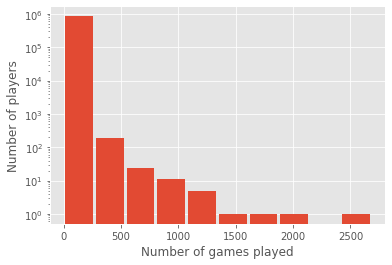

In [22]:
plt.style.use('ggplot')
plt.hist(plays_df['player'].value_counts().values, rwidth=0.9)
plt.yscale('log')
plt.xlabel('Number of games played')
plt.ylabel('Number of players')
plt.show()

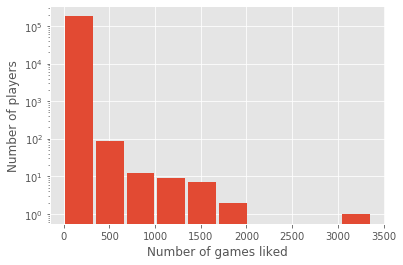

In [23]:
plt.style.use('ggplot')
plt.hist(likes_df['player'].value_counts().values, rwidth=0.9)
plt.yscale('log')
plt.xlabel('Number of games liked')
plt.ylabel('Number of players')
plt.show()

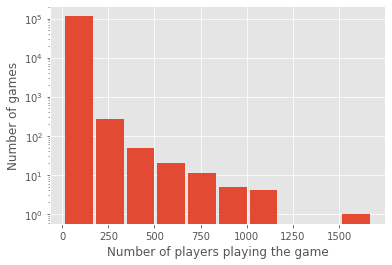

In [24]:
plt.style.use('ggplot')
plt.hist(plays_df['id'].value_counts().values, rwidth=0.9)
plt.yscale('log')
plt.xlabel('Number of players playing the game')
plt.ylabel('Number of games')
plt.show()

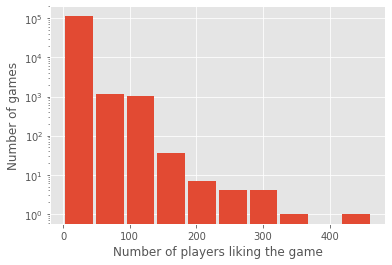

In [25]:
plt.style.use('ggplot')
plt.hist(likes_df['id'].value_counts().values, rwidth=0.9)
plt.yscale('log')
plt.xlabel('Number of players liking the game')
plt.ylabel('Number of games')
plt.show()

### 3. Baseline recommendation system.

A baseline recommendation system can be developed as below:
1. An average like score $G_L$ for each game can be calculated as a fraction of the players liking the game out of all players that played the game.
2. Simillarly, for each player, a like score $P_L$ can be calculated as fraction of games liked by the user, out of all games played by the user.
3. For the games NOT played by the user $i$ the probability of player $i$ liking game $j$ can be calculated as:
$P_{i,j} = P_L^i \times G_L^j$
4. For the purpose of testing this system. We will set aside $1000$ players and $1000$ games as test data.

Selecting test dataset:

*   Since the game plays and likes matrix is sparse, randomly selecting 1000 users and 1000 games will not work, as it is likely that we will get very few plays or likes out of possible $1000 \times 1000 = 10^6$ possible data points.
*   To address this problem we use a simple strategy of selecting 500 players with highest number of games played and 500 players with highest number of games liked, for test dataset.
*   Simillarly, 500 games which are played most and 500 games which are liked most are selected for test dataset.
*   This strategy is quite crude and needs to be refined further to select players and games from all over the distribution and not just most frequent ones.


 

In [26]:
test_players = list(plays_df['player'].value_counts().index[:500]) + list(likes_df['player'].value_counts().index[:500])

In [27]:
test_games = list(plays_df['id'].value_counts().index[:500]) + list(likes_df['id'].value_counts().index[:500])

In [28]:
plays_df_train = plays_df[~plays_df['id'].isin(test_games)]
p_plays_data = pd.DataFrame(plays_df_train['player'].value_counts())
p_plays_data.reset_index(inplace=True)
p_plays_data.columns = ['player', 'plays']
p_plays_data.head()

,player,plays
0,Conducteur59220,2585
1,dellbox2,1949
2,AE4WiiU,1666
3,revolv23,1423
4,demonhunter47223,1240


In [29]:
likes_df_train = likes_df[~likes_df['id'].isin(test_games)]
p_likes_data = pd.DataFrame(likes_df_train['player'].value_counts())
p_likes_data.reset_index(inplace=True)
p_likes_data.columns = ['player', 'likes']
p_likes_data.head()

,player,likes
0,Conducteur59220,3223
1,dellbox2,1934
2,Leeshino,1786
3,revolv23,1564
4,WIIMoustique,1505


Combine these with players dataframe.

In [30]:
plr_ply_df = players_df.merge(p_plays_data, how='left', on='player')
plr_ply_like_df = plr_ply_df.merge(p_likes_data, how='left', on='player')
plr_ply_like_df.head()

,player,plays,likes
0,NolramImpro,4.0,3.0
1,SGK2017,50.0,19.0
2,preamstrikbiz0,13.0,2.0
3,gotatari,51.0,1.0
4,skrufpanda,264.0,23.0


Calculate score for each player as ration of games liked to games played. There is small fraction of players where number of games liked is more than number of games played. We will set score for these cases to 1.

In [31]:
def calc_frac(a):
  if a[1]==0:
    return 0
  else:
    return(min(a[2]/a[1], 1.0))

In [32]:
plr_ply_like_df['score'] = plr_ply_like_df.apply(calc_frac, axis=1)
plr_ply_like_df.head()

,player,plays,likes,score
0,NolramImpro,4.0,3.0,0.750000
1,SGK2017,50.0,19.0,0.380000
2,preamstrikbiz0,13.0,2.0,0.153846
3,gotatari,51.0,1.0,0.019608
4,skrufpanda,264.0,23.0,0.087121


Repeat same calculations for games.

In [33]:
plays_df_train = plays_df[~plays_df['player'].isin(test_players)]
g_plays_data = pd.DataFrame(plays_df_train['id'].value_counts())
g_plays_data.reset_index(inplace=True)
g_plays_data.columns = ['game', 'plays']
g_plays_data.head()

,game,plays
0,5AB9-0000-038F-A23E,1641
1,F44D-0000-035E-496C,1119
2,DE4D-0000-035D-3AE1,1061
3,A4E1-0000-038D-0EBC,1003
4,8F40-0000-0391-4B50,959


In [34]:
likes_df_train = likes_df[~likes_df['player'].isin(test_players)]
g_likes_data = pd.DataFrame(likes_df_train['id'].value_counts())
g_likes_data.reset_index(inplace=True)
g_likes_data.columns = ['game', 'likes']
g_likes_data.head()

,game,likes
0,DE4D-0000-035D-3AE1,429
1,BAC8-0000-036A-7EE1,308
2,5AB9-0000-038F-A23E,297
3,CEB8-0000-0353-A31E,293
4,F44D-0000-035E-496C,292


In [35]:
gm_ply_df = course_df.merge(g_plays_data, how='left', on='game')
gm_ply_like_df = gm_ply_df.merge(g_likes_data, how='left', on='game')
gm_ply_like_df['score'] = gm_ply_like_df.apply(calc_frac, axis=1)
gm_ply_like_df.head()

,game,plays,likes,score
0,079D-0000-0351-17E2,18,1.0,0.055556
1,07CD-0000-030D-EA60,22,1.0,0.045455
2,07F7-0000-030F-A51B,71,9.0,0.126761
3,080E-0000-0307-A394,30,2.0,0.066667
4,082F-0000-0358-A218,20,2.0,0.100000


Create a matrix for true labels on test data sets of 1000 players vs 1000 games.

In [36]:
true_labels = np.ones((1000, 1000)) * -1

In [37]:
for p, plr in enumerate(test_players):
  temp_plays_df = plays_df[plays_df['player']==plr]
  temp_likes_df =  likes_df[likes_df['player']==plr]
  for g, gm in enumerate(test_games):
    # check if player 'plr' has played the game 'gm', then set label to zero
    if gm in temp_plays_df['id'].values:
      true_labels[p, g] = 0
    # check if player 'plr has liked the game 'gm', then set label to 1.
    if gm in temp_likes_df['id'].values:
      true_labels[p, g] = 1

In [38]:
predicted_labels = np.ones((1000,1000)) * -1

Calculate the probability of a player liking a game on test dataset (predictions)

In [39]:
for p, plr in enumerate(test_players):
  temp_plays_df = plr_ply_like_df[plr_ply_like_df['player']==plr]  
  for g, gm in enumerate(test_games):
    if true_labels[p, g] != -1:
      p_s = temp_plays_df['score'].values[0]
      g_s = gm_ply_like_df[gm_ply_like_df['game']==gm]['score'].values[0]
      predicted_labels[p, g] =  p_s * g_s

Flatten the true and predicted label matrices and remove entries of -1.

In [40]:
threshold = 0.5 # Default threshold 0f 0.5
true_flattened = []
predicted_flattened = []
predicted_prob_flattened = []
for i in range(1000):
  for j in range(1000):
    if true_labels[i,j]!=-1:
      true_flattened.append(true_labels[i,j])
      predicted_prob_flattened.append(predicted_labels[i,j])
      if predicted_labels[i,j]>threshold:
        predicted_flattened.append(1)
      else:
        predicted_flattened.append(0)

Calculate accuracy

In [63]:
print('Accuracy on test dataset: {0:4.2f}%'.format(accuracy_score(true_flattened, predicted_flattened)*100))
#labels = ['true_flattened', 'predicted_flattened']
cm = confusion_matrix(true_flattened, predicted_flattened)
cm

Accuracy on test dataset: 35.66%


array([[ 5318,   240],
       [26776,  9653]])

Comments:
The low accuracy of the baseline method can be due to following factor:
*  We have selected test players and games from high frequecy region of the distribution. A more balanced selection of test data might be better representative of overall data. Our selected data is having high probablility of liking the game, but the average on overall dataset might be much lower, hence out predictions will be biased towards **dislike** (0 score) as indicated by the results above.